<a href="https://www.kaggle.com/code/dilekdd/iyzico-forecasting-timeseries?scriptVersionId=229897289" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

Iyzico is a financial technology company that simplifies the online shopping experience for both buyers and sellers. It provides payment infrastructure for e-commerce companies, marketplaces, and individual users.

The goal is to forecast the total transaction volume on a daily basis for each merchant_id during the last 3 months of 2020 (October, November, December)

## 📘 Data Dictionary

The dataset contains **4 variables** and **7,667 observations**.

| Variable Name       | Description                                                        |
|---------------------|--------------------------------------------------------------------|
| `transaction_date`  | Date of the sales transaction.                                     |
| `merchant_id`       | Unique ID for each merchant (distinct per merchant).              |
| `Total_Transaction` | Number of transactions for that merchant on the given date.       |
| `Total_Paid`        | Total payment amount received by the merchant.                    |


In [1]:
# Importing the libraries and adjusting the display settings
import time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
import warnings
!pip install optuna

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
warnings.filterwarnings('ignore')

In [2]:
# summarising the dataset
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)
    #print(dataframe.select_dtypes(include='number').quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)



In [3]:
########################
# Loading the data
########################

df = pd.read_csv('/kaggle/input/iyzico-payment-transaction-fraud-data/iyzico_data.csv', parse_dates=['transaction_date'])

df.head()

,Unnamed: 0,transaction_date,merchant_id,Total_Transaction,Total_Paid
0,0,2018-01-01,535,349,25883.226
1,1,2018-01-01,42616,141,40918.860
2,2,2018-01-01,46774,410,306902.700
3,3,2018-01-01,86302,10,11.340
4,4,2018-01-01,124381,285,111383.766


#####################################################
# Exploratory Data Analysis
#####################################################

In [4]:
df["transaction_date"].min() # Timestamp('2018-01-01 00:00:00')


Timestamp('2018-01-01 00:00:00')

In [5]:
df["transaction_date"].max() # Timestamp('2020-12-31 00:00:00')

Timestamp('2020-12-31 00:00:00')

In [6]:
check_df(df)

##################### Shape #####################
(7667, 5)
##################### Types #####################
Unnamed: 0                    int64
transaction_date     datetime64[ns]
merchant_id                   int64
Total_Transaction             int64
Total_Paid                  float64
dtype: object
##################### Head #####################
   Unnamed: 0 transaction_date  merchant_id  Total_Transaction  Total_Paid
0           0       2018-01-01          535                349   25883.226
1           1       2018-01-01        42616                141   40918.860
2           2       2018-01-01        46774                410  306902.700
3           3       2018-01-01        86302                 10      11.340
4           4       2018-01-01       124381                285  111383.766
##################### Tail #####################
      Unnamed: 0 transaction_date  merchant_id  Total_Transaction   Total_Paid
7662        7662       2020-12-31        46774               3394  31

In [7]:
# Removing the Unnamed column
df.drop("Unnamed: 0", axis=1,  inplace=True)
df.head()

,transaction_date,merchant_id,Total_Transaction,Total_Paid
0,2018-01-01,535,349,25883.226
1,2018-01-01,42616,141,40918.860
2,2018-01-01,46774,410,306902.700
3,2018-01-01,86302,10,11.340
4,2018-01-01,124381,285,111383.766


In [8]:
# unique merchant_id and count of total unique merchant_id
df['merchant_id'].nunique() # 7

7

In [9]:
df['merchant_id'].unique() #Out[13]: array([   535,  42616,  46774,  86302, 124381, 129316,  57192])

array([   535,  42616,  46774,  86302, 124381, 129316,  57192])

In [10]:
# Sum of Total_paid by merchant_id
df.groupby('merchant_id')['Total_Paid'].sum()

merchant_id
535       1.566015e+08
42616     3.545831e+08
46774     1.567200e+09
57192     3.173371e+08
86302     2.870447e+06
124381    1.158693e+09
129316    1.555471e+06
Name: Total_Paid, dtype: float64

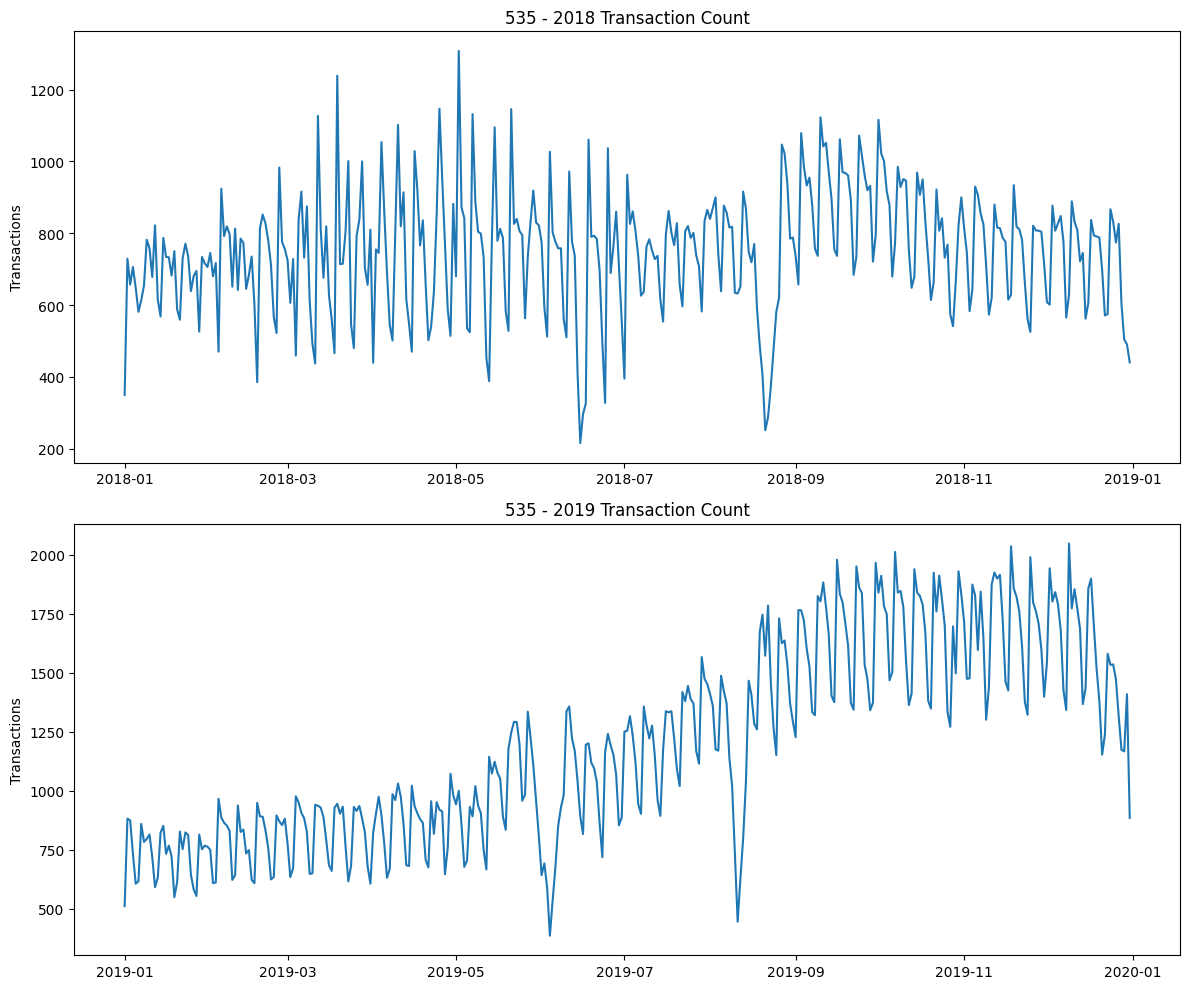

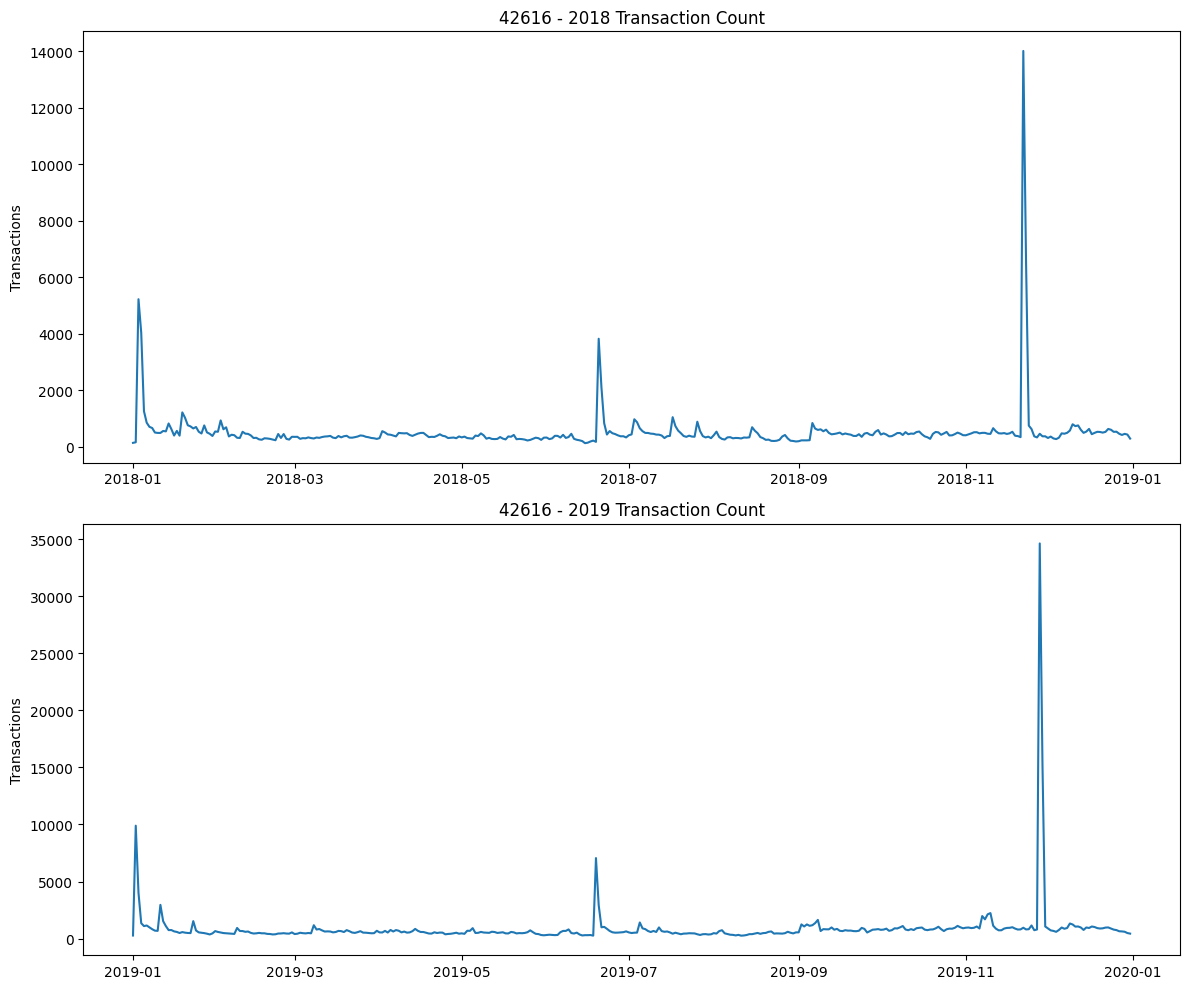

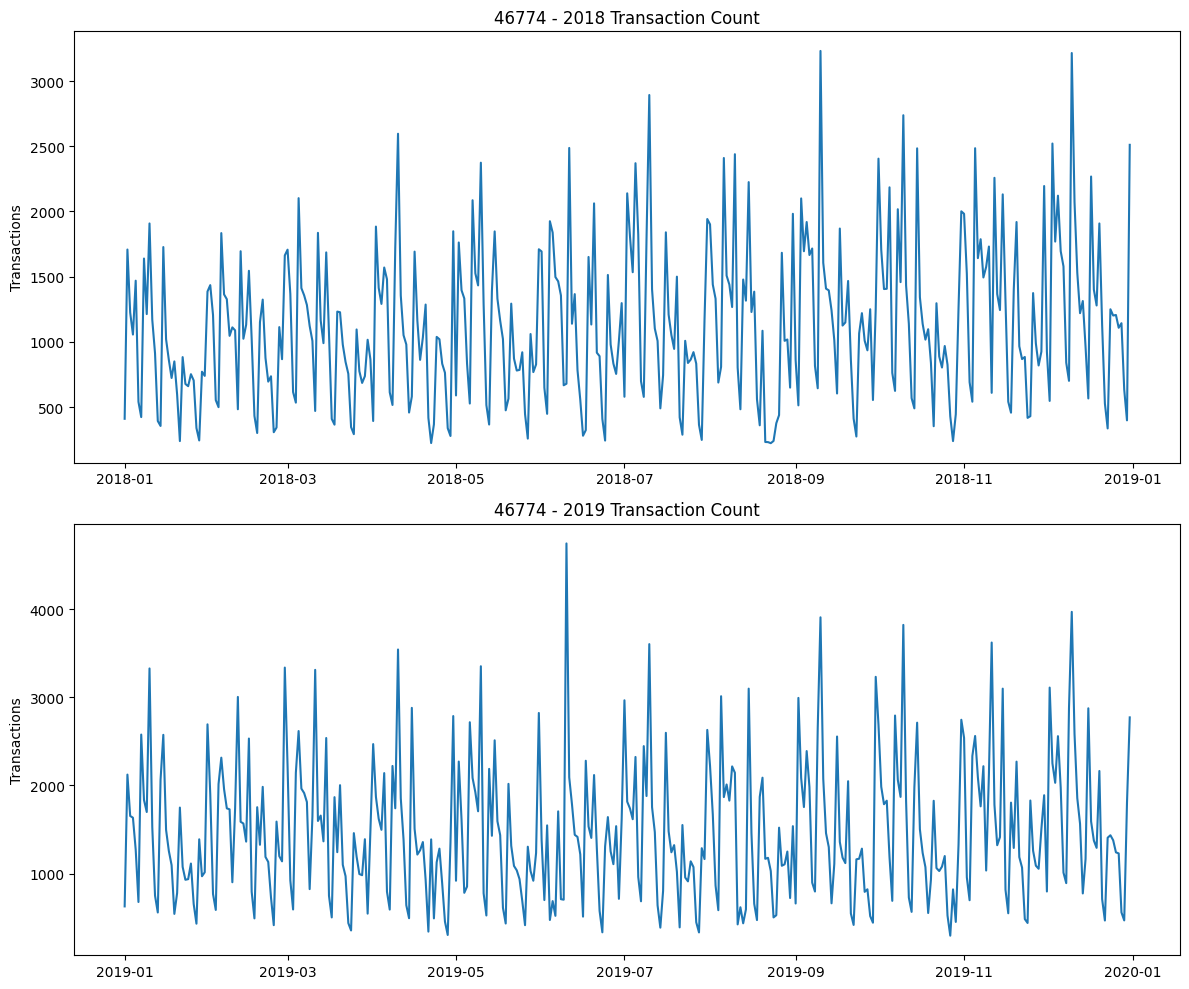

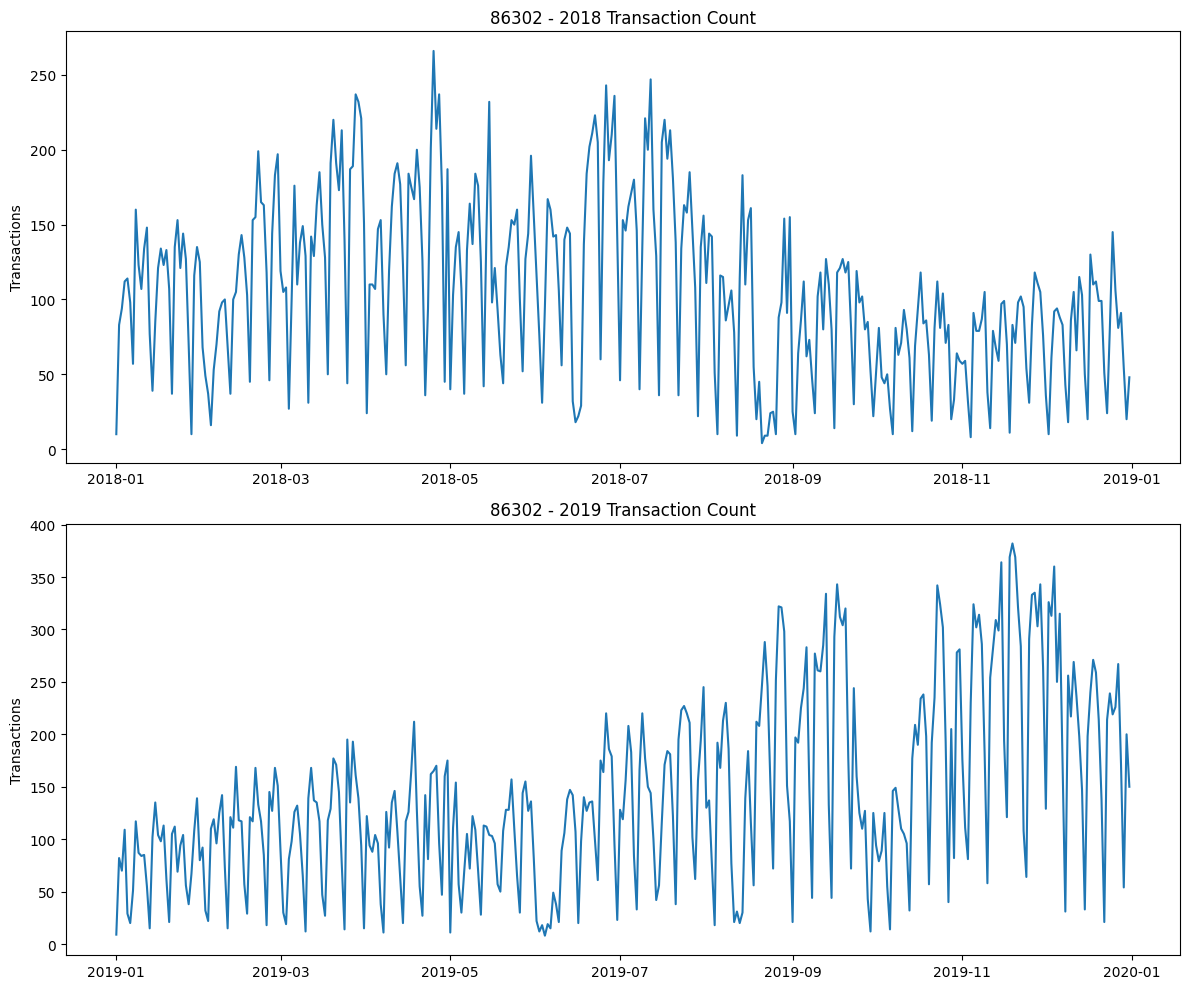

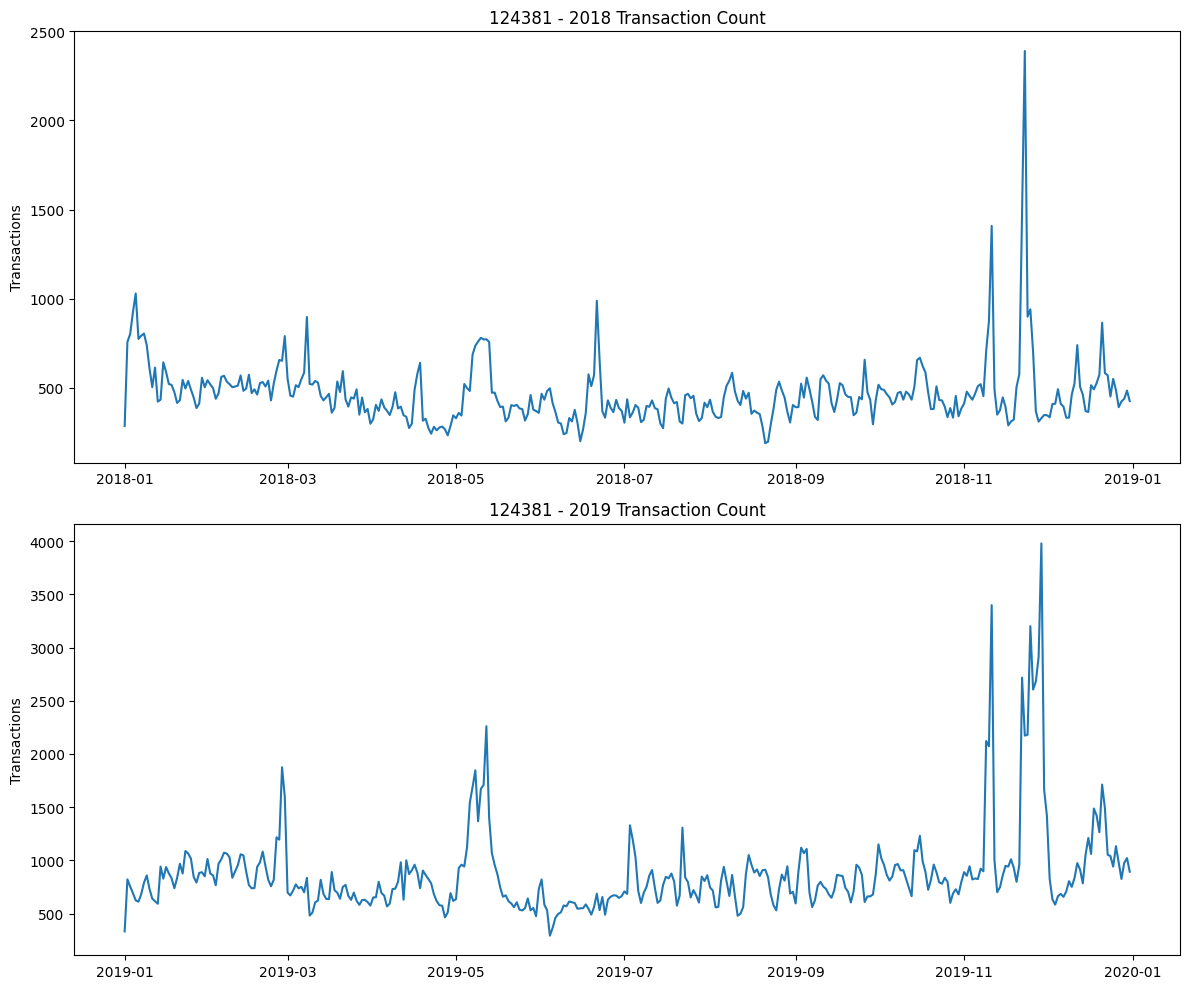

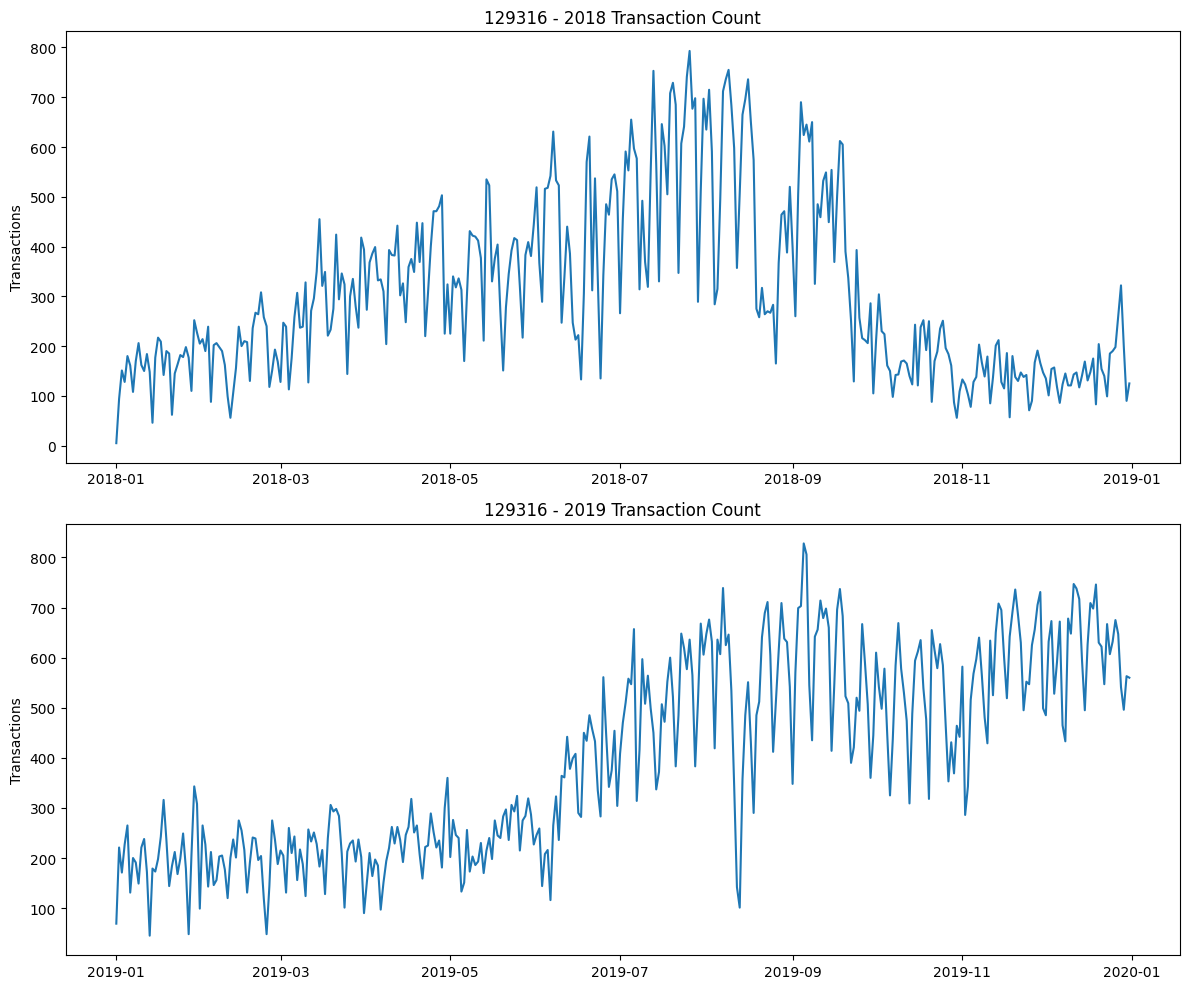

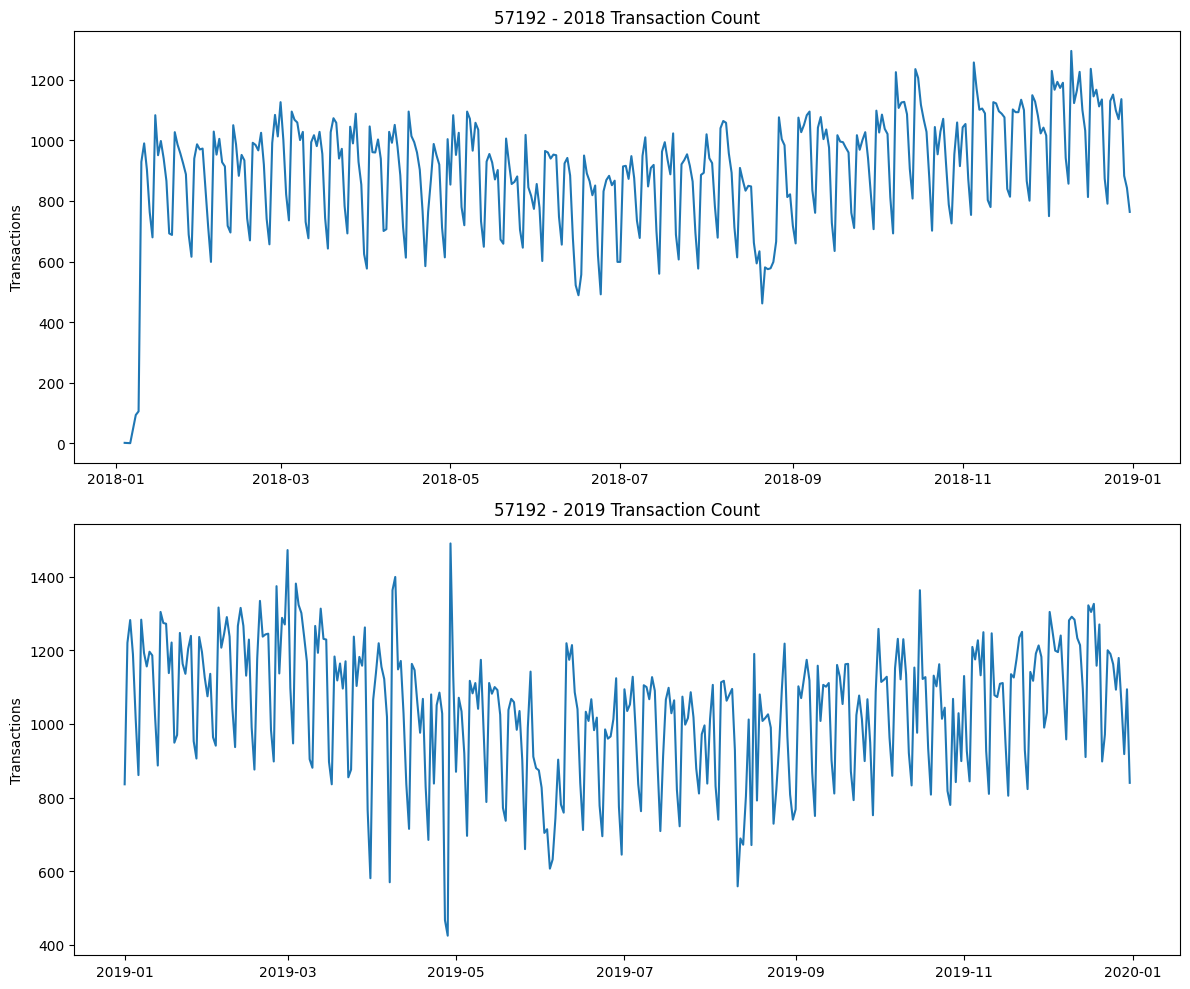

In [11]:
# Visualizes yearly transaction trends (Total_Transaction) for each merchant_id in the dataset.
def plot_transaction_trends(df, years, merchant_col='merchant_id', date_col='transaction_date', target_col='Total_Transaction'):
    for merchant in df[merchant_col].unique():
        plt.figure(figsize=(12, 5 * len(years)))
        for i, year in enumerate(years):
            plt.subplot(len(years), 1, i+1) #plt.subplot(n_rows, n_cols, plot_index)
            yearly_data = df[
                (df[merchant_col] == merchant) &
                (df[date_col] >= f"{year}-01-01") &
                (df[date_col] < f"{year+1}-01-01")
            ]
            plt.plot(yearly_data[date_col], yearly_data[target_col])
            plt.title(f"{merchant} - {year} Transaction Count")
            plt.xlabel('')
            plt.ylabel('Transactions')
        plt.tight_layout()
        plt.show()

plot_transaction_trends(df, years=[2018, 2019])


#####################################################
# FEATURE ENGINEERING
#####################################################

In [12]:
def create_date_features(df, date_column):
    df['month'] = df[date_column].dt.month
    df['day_of_month'] = df[date_column].dt.day
    df['day_of_year'] = df[date_column].dt.dayofyear
    df['week_of_year'] = df[date_column].dt.isocalendar().week
    df['day_of_week'] = df[date_column].dt.dayofweek
    df['year'] = df[date_column].dt.year
    df['is_wknd'] = (df[date_column].dt.weekday // 4).astype(int)
    df['is_month_start'] = df[date_column].dt.is_month_start.astype(int)
    df['is_month_end'] = df[date_column].dt.is_month_end.astype(int)
    df['quarter'] = df[date_column].dt.quarter
    df['is_quarter_start'] = df[date_column].dt.is_quarter_start.astype(int)
    df['is_quarter_end'] = df[date_column].dt.is_quarter_end.astype(int)
    df['is_year_start'] = df[date_column].dt.is_year_start.astype(int)
    df['is_year_end'] = df[date_column].dt.is_year_end.astype(int)
    return df

# Apply the function
df = create_date_features(df, "transaction_date")
df.head()

,transaction_date,merchant_id,Total_Transaction,Total_Paid,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,quarter,is_quarter_start,is_quarter_end,is_year_start,is_year_end
0,2018-01-01,535,349,25883.226,1,1,1,1,0,2018,0,1,0,1,1,0,1,0
1,2018-01-01,42616,141,40918.860,1,1,1,1,0,2018,0,1,0,1,1,0,1,0
2,2018-01-01,46774,410,306902.700,1,1,1,1,0,2018,0,1,0,1,1,0,1,0
3,2018-01-01,86302,10,11.340,1,1,1,1,0,2018,0,1,0,1,1,0,1,0
4,2018-01-01,124381,285,111383.766,1,1,1,1,0,2018,0,1,0,1,1,0,1,0


In [13]:
# summary of the transaction amount of the merchants by month and year
df.groupby(["merchant_id", "year", "month", "day_of_month"]).agg({
    "Total_Transaction": ["sum", "mean", "median"]
})

Total_Transaction              
                                                  sum   mean median
merchant_id year month day_of_month                                
535         2018 1     1                          349  349.0  349.0
                       2                          729  729.0  729.0
                       3                          657  657.0  657.0
                       4                          706  706.0  706.0
                       5                          648  648.0  648.0
...                                               ...    ...    ...
129316      2020 12    27                         620  620.0  620.0
                       28                         640  640.0  640.0
                       29                         703  703.0  703.0
                       30                         642  642.0  642.0
                       31                         485  485.0  485.0

[7667 rows x 3 columns]

In [14]:
# summary of the total paid amount of the merchants by month and year
df.groupby(["merchant_id", "year", "month"]).agg({
    "Total_Paid": ["sum", "mean", "median"]
}).round(2)

Total_Paid                    
                               sum      mean    median
merchant_id year month                                
535         2018 1      2091231.81  67459.09  71088.66
                 2      2060521.06  73590.04  73345.54
                 3      2371568.27  76502.20  71045.64
                 4      2504558.75  83485.29  83215.55
                 5      2831761.17  91347.13  90838.42
...                            ...       ...       ...
129316      2020 8        72080.10   2325.16   2341.35
                 9        79788.60   2659.62   2627.55
                 10       79789.05   2573.84   2579.40
                 11       80757.45   2691.92   2704.50
                 12       87448.50   2820.92   2815.20

[252 rows x 3 columns]

#####################################################
# LAG/SHIFTED FEATURES
#####################################################

In [15]:
def random_noise(dataframe):
    return np.random.normal(scale=1.6, size=(len(dataframe),))

def lag_features(dataframe, lags):
    for lag in lags:
        dataframe['sales_lag_' + str(lag)] = dataframe.groupby(["merchant_id"])['Total_Transaction'].transform(
            lambda x: x.shift(lag) + np.random.normal(scale=1.6, size=len(x))
        )
    return dataframe

df = lag_features(df, [91, 92, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179,
                       180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190,
                       350, 351, 352, 352, 354, 355, 356, 357, 358, 359, 360,
                       361, 362, 363, 364, 365, 366, 367, 368, 369, 370,
                       538, 539, 540, 541, 542,
                       718, 719, 720, 721, 722])

df.head()

,transaction_date,merchant_id,Total_Transaction,Total_Paid,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,quarter,is_quarter_start,is_quarter_end,is_year_start,is_year_end,sales_lag_91,sales_lag_92,sales_lag_170,sales_lag_171,sales_lag_172,sales_lag_173,sales_lag_174,sales_lag_175,sales_lag_176,sales_lag_177,sales_lag_178,sales_lag_179,sales_lag_180,sales_lag_181,sales_lag_182,sales_lag_183,sales_lag_184,sales_lag_185,sales_lag_186,sales_lag_187,sales_lag_188,sales_lag_189,sales_lag_190,sales_lag_350,sales_lag_351,sales_lag_352,sales_lag_354,sales_lag_355,sales_lag_356,sales_lag_357,sales_lag_358,sales_lag_359,sales_lag_360,sales_lag_361,sales_lag_362,sales_lag_363,sales_lag_364,sales_lag_365,sales_lag_366,sales_lag_367,sales_lag_368,sales_lag_369,sales_lag_370,sales_lag_538,sales_lag_539,sales_lag_540,sales_lag_541,sales_lag_542,sales_lag_718,sales_lag_719,sales_lag_720,sales_lag_721,sales_lag_722
0,2018-01-01,535,349,25883.226,1,1,1,1,0,2018,0,1,0,1,1,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-01-01,42616,141,40918.860,1,1,1,1,0,2018,0,1,0,1,1,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-01-01,46774,410,306902.700,1,1,1,1,0,2018,0,1,0,1,1,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-01-01,86302,10,11.340,1,1,1,1,0,2018,0,1,0,1,1,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-01-01,124381,285,111383.766,1,1,1,1,0,2018,0,1,0,1,1,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#####################################################
# WEIGHTED ROLLING MEAN
#####################################################

In [16]:
def roll_mean_features(dataframe, windows):
    for window in windows:
        dataframe['sales_roll_mean_' + str(window)] = dataframe.groupby("merchant_id")['Total_Transaction'].transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean()
        ) + random_noise(dataframe)
    return dataframe

df = roll_mean_features(df, [91, 92, 178, 179, 180, 181, 182, 359, 360, 361, 449, 450, 451,
                             539, 540, 541, 629, 630, 631, 720])
df.head()

#Shifts the data by 1 day, so we're not using the current day's value (avoiding data leakage).
#rolling function takes the rolling average of defined window. Example, window=180 would mean a rolling average over the past 180 days.
# min_periods=10 allows it to calculate even if fewer than 180 past values are available.if you have at least 10 previous values,
# go ahead and calculate the average — even if it's not the full 180 yet.
# win_type="triang" means values closer to the current date get more weight in the average.
# These help your model learn seasonal trends, long-term averages, and merchant-specific behaviors.

,transaction_date,merchant_id,Total_Transaction,Total_Paid,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,quarter,is_quarter_start,is_quarter_end,is_year_start,is_year_end,sales_lag_91,sales_lag_92,sales_lag_170,sales_lag_171,sales_lag_172,sales_lag_173,sales_lag_174,sales_lag_175,sales_lag_176,sales_lag_177,sales_lag_178,sales_lag_179,sales_lag_180,sales_lag_181,sales_lag_182,sales_lag_183,sales_lag_184,sales_lag_185,sales_lag_186,sales_lag_187,sales_lag_188,sales_lag_189,sales_lag_190,sales_lag_350,sales_lag_351,sales_lag_352,sales_lag_354,sales_lag_355,sales_lag_356,sales_lag_357,sales_lag_358,sales_lag_359,sales_lag_360,sales_lag_361,sales_lag_362,sales_lag_363,sales_lag_364,sales_lag_365,sales_lag_366,sales_lag_367,sales_lag_368,sales_lag_369,sales_lag_370,sales_lag_538,sales_lag_539,sales_lag_540,sales_lag_541,sales_lag_542,sales_lag_718,sales_lag_719,sales_lag_720,sales_lag_721,sales_lag_722,sales_roll_mean_91,sales_roll_mean_92,sales_roll_mean_178,sales_roll_mean_179,sales_roll_mean_180,sales_roll_mean_181,sales_roll_mean_182,sales_roll_mean_359,sales_roll_mean_360,sales_roll_mean_361,sales_roll_mean_449,sales_roll_mean_450,sales_roll_mean_451,sales_roll_mean_539,sales_roll_mean_540,sales_roll_mean_541,sales_roll_mean_629,sales_roll_mean_630,sales_roll_mean_631,sales_roll_mean_720
0,2018-01-01,535,349,25883.226,1,1,1,1,0,2018,0,1,0,1,1,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-01-01,42616,141,40918.860,1,1,1,1,0,2018,0,1,0,1,1,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-01-01,46774,410,306902.700,1,1,1,1,0,2018,0,1,0,1,1,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-01-01,86302,10,11.340,1,1,1,1,0,2018,0,1,0,1,1,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-01-01,124381,285,111383.766,1,1,1,1,0,2018,0,1,0,1,1,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#####################################################
# EXPONENTIALLY WEIGHTED MOVING AVERAGE
#####################################################

In [17]:
def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby("merchant_id")['Total_Transaction'].transform(
                    lambda x: x.shift(lag).ewm(alpha=alpha).mean()
                )
    return dataframe
# - This function takes:
#   - `dataframe`: the full dataset
#   - `alphas`: A list of smoothing factors (how much weight to give to recent vs older values)
#   - `lags`: A list of lag periods (how far back to start the moving average)
# for alpha in alphas:
#     for lag in lags:
#Loop through each combination of smoothing level (alpha) and time shift (lag)

#groupby("merchant_id"): Operate within each merchant's transaction history
# .shift(lag): Shifts the data backward by lag days to prevent data leakage (so we don't include today's value when predicting today)
# .ewm(alpha=alpha).mean(): Calculates an Exponentially Weighted Moving Average, where:
# A higher alpha (e.g., 0.95) puts more weight on recent values
# A lower alpha (e.g., 0.5) smooths more slowly, including older values more evenly


alphas = [0.95, 0.9, 0.8, 0.7, 0.5]
lags = [91, 92, 178, 179, 180, 181, 182, 359, 360, 361, 449, 450, 451, 539, 540, 541, 629, 630, 631, 720]

df = ewm_features(df, alphas, lags)
df.tail()

,transaction_date,merchant_id,Total_Transaction,Total_Paid,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,quarter,is_quarter_start,is_quarter_end,is_year_start,is_year_end,sales_lag_91,sales_lag_92,sales_lag_170,sales_lag_171,sales_lag_172,sales_lag_173,sales_lag_174,sales_lag_175,sales_lag_176,sales_lag_177,sales_lag_178,sales_lag_179,sales_lag_180,sales_lag_181,sales_lag_182,sales_lag_183,sales_lag_184,sales_lag_185,sales_lag_186,sales_lag_187,sales_lag_188,sales_lag_189,sales_lag_190,sales_lag_350,sales_lag_351,sales_lag_352,sales_lag_354,sales_lag_355,sales_lag_356,sales_lag_357,sales_lag_358,sales_lag_359,sales_lag_360,sales_lag_361,sales_lag_362,sales_lag_363,sales_lag_364,sales_lag_365,sales_lag_366,sales_lag_367,sales_lag_368,sales_lag_369,sales_lag_370,sales_lag_538,sales_lag_539,sales_lag_540,sales_lag_541,sales_lag_542,sales_lag_718,sales_lag_719,sales_lag_720,sales_lag_721,sales_lag_722,sales_roll_mean_91,sales_roll_mean_92,sales_roll_mean_178,sales_roll_mean_179,sales_roll_mean_180,sales_roll_mean_181,sales_roll_mean_182,sales_roll_mean_359,sales_roll_mean_360,sales_roll_mean_361,sales_roll_mean_449,sales_roll_mean_450,sales_roll_mean_451,sales_roll_mean_539,sales_roll_mean_540,sales_roll_mean_541,sales_roll_mean_629,sales_roll_mean_630,sales_roll_mean_631,sales_roll_mean_720,sales_ewm_alpha_095_lag_91,sales_ewm_alpha_095_lag_92,sales_ewm_alpha_095_lag_178,sales_ewm_alpha_095_lag_179,sales_ewm_alpha_095_lag_180,sales_ewm_alpha_095_lag_181,sales_ewm_alpha_095_lag_182,sales_ewm_alpha_095_lag_359,sales_ewm_alpha_095_lag_360,sales_ewm_alpha_095_lag_361,sales_ewm_alpha_095_lag_449,sales_ewm_alpha_095_lag_450,sales_ewm_alpha_095_lag_451,sales_ewm_alpha_095_lag_539,sales_ewm_alpha_095_lag_540,sales_ewm_alpha_095_lag_541,sales_ewm_alpha_095_lag_629,sales_ewm_alpha_095_lag_630,sales_ewm_alpha_095_lag_631,sales_ewm_alpha_095_lag_720,sales_ewm_alpha_09_lag_91,sales_ewm_alpha_09_lag_92,sales_ewm_alpha_09_lag_178,sales_ewm_alpha_09_lag_179,sales_ewm_alpha_09_lag_180,sales_ewm_alpha_09_lag_181,sales_ewm_alpha_09_lag_182,sales_ewm_alpha_09_lag_359,sales_ewm_alpha_09_lag_360,sales_ewm_alpha_09_lag_361,sales_ewm_alpha_09_lag_449,sales_ewm_alpha_09_lag_450,sales_ewm_alpha_09_lag_451,sales_ewm_alpha_09_lag_539,sales_ewm_alpha_09_lag_540,sales_ewm_alpha_09_lag_541,sales_ewm_alpha_09_lag_629,sales_ewm_alpha_09_lag_630,sales_ewm_alpha_09_lag_631,sales_ewm_alpha_09_lag_720,sales_ewm_alpha_08_lag_91,sales_ewm_alpha_08_lag_92,sales_ewm_alpha_08_lag_178,sales_ewm_alpha_08_lag_179,sales_ewm_alpha_08_lag_180,sales_ewm_alpha_08_lag_181,sales_ewm_alpha_08_lag_182,sales_ewm_alpha_08_lag_359,sales_ewm_alpha_08_lag_360,sales_ewm_alpha_08_lag_361,sales_ewm_alpha_08_lag_449,sales_ewm_alpha_08_lag_450,sales_ewm_alpha_08_lag_451,sales_ewm_alpha_08_lag_539,sales_ewm_alpha_08_lag_540,sales_ewm_alpha_08_lag_541,sales_ewm_alpha_08_lag_629,sales_ewm_alpha_08_lag_630,sales_ewm_alpha_08_lag_631,sales_ewm_alpha_08_lag_720,sales_ewm_alpha_07_lag_91,sales_ewm_alpha_07_lag_92,sales_ewm_alpha_07_lag_178,sales_ewm_alpha_07_lag_179,sales_ewm_alpha_07_lag_180,sales_ewm_alpha_07_lag_181,sales_ewm_alpha_07_lag_182,sales_ewm_alpha_07_lag_359,sales_ewm_alpha_07_lag_360,sales_ewm_alpha_07_lag_361,sales_ewm_alpha_07_lag_449,sales_ewm_alpha_07_lag_450,sales_ewm_alpha_07_lag_451,sales_ewm_alpha_07_lag_539,sales_ewm_alpha_07_lag_540,sales_ewm_alpha_07_lag_541,sales_ewm_alpha_07_lag_629,sales_ewm_alpha_07_lag_630,sales_ewm_alpha_07_lag_631,sales_ewm_alpha_07_lag_720,sales_ewm_alpha_05_lag_91,sales_ewm_alpha_05_lag_92,sales_ewm_alpha_05_lag_178,sales_ewm_alpha_05_lag_179,sales_ewm_alpha_05_lag_180,sales_ewm_alpha_05_lag_181,sales_ewm_alpha_05_lag_182,sales_ewm_alpha_05_lag_359,sales_ewm_alpha_05_lag_360,sales_ewm_alpha_05_lag_361,sales_ewm_alpha_05_lag_449,sales_ewm_alpha_05_lag_450,sales_ewm_alpha_05_lag_451,sales_ewm_alpha_05_lag_539,sales_ewm_alpha_05_lag_540,sales_ewm_alpha_05_lag_541,sales_ewm_alpha_05_lag_629,sales_ewm_a

############################
# Black Friday - Summer Solstice
############################

In [18]:
df["is_black_friday"] = 0
df.loc[df["transaction_date"].isin(["2018-11-22", "2018-11-23", "2019-11-29", "2019-11-30"]), "is_black_friday"] = 1

df["is_summer_solstice"] = 0
df.loc[df["transaction_date"].isin([
    "2018-06-19", "2018-06-20", "2018-06-21", "2018-06-22",
    "2019-06-19", "2019-06-20", "2019-06-21", "2019-06-22"
]), "is_summer_solstice"] = 1

df.tail()

,transaction_date,merchant_id,Total_Transaction,Total_Paid,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,quarter,is_quarter_start,is_quarter_end,is_year_start,is_year_end,sales_lag_91,sales_lag_92,sales_lag_170,sales_lag_171,sales_lag_172,sales_lag_173,sales_lag_174,sales_lag_175,sales_lag_176,sales_lag_177,sales_lag_178,sales_lag_179,sales_lag_180,sales_lag_181,sales_lag_182,sales_lag_183,sales_lag_184,sales_lag_185,sales_lag_186,sales_lag_187,sales_lag_188,sales_lag_189,sales_lag_190,sales_lag_350,sales_lag_351,sales_lag_352,sales_lag_354,sales_lag_355,sales_lag_356,sales_lag_357,sales_lag_358,sales_lag_359,sales_lag_360,sales_lag_361,sales_lag_362,sales_lag_363,sales_lag_364,sales_lag_365,sales_lag_366,sales_lag_367,sales_lag_368,sales_lag_369,sales_lag_370,sales_lag_538,sales_lag_539,sales_lag_540,sales_lag_541,sales_lag_542,sales_lag_718,sales_lag_719,sales_lag_720,sales_lag_721,sales_lag_722,sales_roll_mean_91,sales_roll_mean_92,sales_roll_mean_178,sales_roll_mean_179,sales_roll_mean_180,sales_roll_mean_181,sales_roll_mean_182,sales_roll_mean_359,sales_roll_mean_360,sales_roll_mean_361,sales_roll_mean_449,sales_roll_mean_450,sales_roll_mean_451,sales_roll_mean_539,sales_roll_mean_540,sales_roll_mean_541,sales_roll_mean_629,sales_roll_mean_630,sales_roll_mean_631,sales_roll_mean_720,sales_ewm_alpha_095_lag_91,sales_ewm_alpha_095_lag_92,sales_ewm_alpha_095_lag_178,sales_ewm_alpha_095_lag_179,sales_ewm_alpha_095_lag_180,sales_ewm_alpha_095_lag_181,sales_ewm_alpha_095_lag_182,sales_ewm_alpha_095_lag_359,sales_ewm_alpha_095_lag_360,sales_ewm_alpha_095_lag_361,sales_ewm_alpha_095_lag_449,sales_ewm_alpha_095_lag_450,sales_ewm_alpha_095_lag_451,sales_ewm_alpha_095_lag_539,sales_ewm_alpha_095_lag_540,sales_ewm_alpha_095_lag_541,sales_ewm_alpha_095_lag_629,sales_ewm_alpha_095_lag_630,sales_ewm_alpha_095_lag_631,sales_ewm_alpha_095_lag_720,sales_ewm_alpha_09_lag_91,sales_ewm_alpha_09_lag_92,sales_ewm_alpha_09_lag_178,sales_ewm_alpha_09_lag_179,sales_ewm_alpha_09_lag_180,sales_ewm_alpha_09_lag_181,sales_ewm_alpha_09_lag_182,sales_ewm_alpha_09_lag_359,sales_ewm_alpha_09_lag_360,sales_ewm_alpha_09_lag_361,sales_ewm_alpha_09_lag_449,sales_ewm_alpha_09_lag_450,sales_ewm_alpha_09_lag_451,sales_ewm_alpha_09_lag_539,sales_ewm_alpha_09_lag_540,sales_ewm_alpha_09_lag_541,sales_ewm_alpha_09_lag_629,sales_ewm_alpha_09_lag_630,sales_ewm_alpha_09_lag_631,sales_ewm_alpha_09_lag_720,sales_ewm_alpha_08_lag_91,sales_ewm_alpha_08_lag_92,sales_ewm_alpha_08_lag_178,sales_ewm_alpha_08_lag_179,sales_ewm_alpha_08_lag_180,sales_ewm_alpha_08_lag_181,sales_ewm_alpha_08_lag_182,sales_ewm_alpha_08_lag_359,sales_ewm_alpha_08_lag_360,sales_ewm_alpha_08_lag_361,sales_ewm_alpha_08_lag_449,sales_ewm_alpha_08_lag_450,sales_ewm_alpha_08_lag_451,sales_ewm_alpha_08_lag_539,sales_ewm_alpha_08_lag_540,sales_ewm_alpha_08_lag_541,sales_ewm_alpha_08_lag_629,sales_ewm_alpha_08_lag_630,sales_ewm_alpha_08_lag_631,sales_ewm_alpha_08_lag_720,sales_ewm_alpha_07_lag_91,sales_ewm_alpha_07_lag_92,sales_ewm_alpha_07_lag_178,sales_ewm_alpha_07_lag_179,sales_ewm_alpha_07_lag_180,sales_ewm_alpha_07_lag_181,sales_ewm_alpha_07_lag_182,sales_ewm_alpha_07_lag_359,sales_ewm_alpha_07_lag_360,sales_ewm_alpha_07_lag_361,sales_ewm_alpha_07_lag_449,sales_ewm_alpha_07_lag_450,sales_ewm_alpha_07_lag_451,sales_ewm_alpha_07_lag_539,sales_ewm_alpha_07_lag_540,sales_ewm_alpha_07_lag_541,sales_ewm_alpha_07_lag_629,sales_ewm_alpha_07_lag_630,sales_ewm_alpha_07_lag_631,sales_ewm_alpha_07_lag_720,sales_ewm_alpha_05_lag_91,sales_ewm_alpha_05_lag_92,sales_ewm_alpha_05_lag_178,sales_ewm_alpha_05_lag_179,sales_ewm_alpha_05_lag_180,sales_ewm_alpha_05_lag_181,sales_ewm_alpha_05_lag_182,sales_ewm_alpha_05_lag_359,sales_ewm_alpha_05_lag_360,sales_ewm_alpha_05_lag_361,sales_ewm_alpha_05_lag_449,sales_ewm_alpha_05_lag_450,sales_ewm_alpha_05_lag_451,sales_ewm_alpha_05_lag_539,sales_ewm_alpha_05_lag_540,sales_ewm_alpha_05_lag_541,sales_ewm_alpha_05_lag_629,sales_ewm_a

In [19]:
############# Copy of the original df ######

submission = df[df["transaction_date"] >= "2020-10-01"][["merchant_id", "transaction_date"]].copy()
submission.head()


,merchant_id,transaction_date
7023,535,2020-10-01
7024,42616,2020-10-01
7025,46774,2020-10-01
7026,57192,2020-10-01
7027,86302,2020-10-01


############################
# ONE HOT ENCODING
############################

In [20]:
# Although 'merchant_id', 'day_of_week', and 'month' are represented as numerical values,
# they are actually categorical variables with no inherent order or hierarchy.
# Without encoding, machine learning models might incorrectly interpret them as ordinal features.
# To avoid this and ensure correct interpretation, we apply One-Hot Encoding (OHE),
# which creates separate binary features for each category.
df = pd.get_dummies(df, columns=['merchant_id', 'day_of_week', 'month'])


# It’s used to reduce the impact of large values and make the data more normally distributed.
# Especially helpful when the feature is right-skewed (i.e., has a long tail of large values).
# When the feature has positive values only.
df['Total_Transaction'] = np.log1p(df["Total_Transaction"].values)


########################
# Custom Cost Function
########################

In [21]:
# MAE, MSE, RMSE, SSE

# MAE: mean absolute error
# MAPE: mean absolute percentage error
# SMAPE: Symmetric mean absolute percentage error (adjusted MAPE)
# the lower the better

def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds - target)
    denom = np.abs(preds) + np.abs(target)
    smape_val = (200 * np.sum(num / denom)) / n
    return smape_val


def lgbm_smape(preds, train_data):
    labels = train_data.get_label()
    smape_val = smape(np.expm1(preds), np.expm1(labels))
    return 'SMAPE', smape_val, False


########################
# Time-Based Train / Validation Sets
########################

In [22]:
import re

df = df.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))

# Training set: Until October 2020
train = df.loc[df["transaction_date"] < "2020-10-01", :]

# Validation set: Last 3 months of 2020
val = df.loc[df["transaction_date"] >= "2020-10-01", :]

cols = [col for col in train.columns if col not in ['transaction_date', 'id', 'Total_Transaction', 'Total_Paid', 'year']]

Y_train = train['Total_Transaction']
X_train = train[cols]

Y_val = val['Total_Transaction']
X_val = val[cols]

Y_train.shape, X_train.shape, Y_val.shape, X_val.shape

((7023,), (7023, 212), (644,), (644, 212))

########################
# LIGHTGBM MODEL
########################

In [23]:

import optuna
from lightgbm import Dataset, train

from lightgbm import train, Dataset, early_stopping, log_evaluation
from sklearn.metrics import mean_absolute_error

def objective(trial):
    param_grid = {
        'metric': 'None',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'nthread': -1,
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 0.9),
        'num_leaves': trial.suggest_int('num_leaves', 10, 100),
        'max_depth': trial.suggest_int('max_depth', 3, 10)
    }

    lgb_train = Dataset(X_train, label=Y_train, feature_name=cols)
    lgb_valid = Dataset(X_val, label=Y_val, reference=lgb_train, feature_name=cols)

    model = train(
        param_grid,
        lgb_train,
        valid_sets=[lgb_valid],
        num_boost_round=10000,
        feval=lgbm_smape,
        callbacks=[
            early_stopping(200),
            log_evaluation(0)  # 0 = silent, 100 = log every 100 rounds
        ]
    )

    y_pred = model.predict(X_val, num_iteration=model.best_iteration)
    score = mean_absolute_error(np.expm1(Y_val), np.expm1(y_pred))  # or use smape()

    return score

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

print("Best trial:")
print(study.best_trial.params)

[I 2025-03-26 22:53:48,293] A new study created in memory with name: no-name-4a4e2ee4-b4ec-4915-b317-35a30865ce8f


Training until validation scores don't improve for 200 rounds


[I 2025-03-26 22:53:51,331] Trial 0 finished with value: 606.3183696821424 and parameters: {'learning_rate': 0.04943226500690476, 'feature_fraction': 0.791898747649173, 'num_leaves': 44, 'max_depth': 6}. Best is trial 0 with value: 606.3183696821424.


Early stopping, best iteration is:
[109]	valid_0's SMAPE: 22.6241
Training until validation scores don't improve for 200 rounds


[I 2025-03-26 22:53:56,203] Trial 1 finished with value: 597.2068638147698 and parameters: {'learning_rate': 0.09983270901197527, 'feature_fraction': 0.7739893958966693, 'num_leaves': 57, 'max_depth': 8}. Best is trial 1 with value: 597.2068638147698.


Early stopping, best iteration is:
[194]	valid_0's SMAPE: 22.9961
Training until validation scores don't improve for 200 rounds


[I 2025-03-26 22:54:03,520] Trial 2 finished with value: 591.2985354342605 and parameters: {'learning_rate': 0.022361750987185555, 'feature_fraction': 0.44789235359196344, 'num_leaves': 84, 'max_depth': 8}. Best is trial 2 with value: 591.2985354342605.


Early stopping, best iteration is:
[567]	valid_0's SMAPE: 22.0325
Training until validation scores don't improve for 200 rounds


[I 2025-03-26 22:54:08,317] Trial 3 finished with value: 605.6480231978511 and parameters: {'learning_rate': 0.08182909785313316, 'feature_fraction': 0.62196784761228, 'num_leaves': 75, 'max_depth': 9}. Best is trial 2 with value: 591.2985354342605.


Early stopping, best iteration is:
[193]	valid_0's SMAPE: 22.9654
Training until validation scores don't improve for 200 rounds


[I 2025-03-26 22:54:09,039] Trial 4 finished with value: 573.9490729702254 and parameters: {'learning_rate': 0.09604339925213046, 'feature_fraction': 0.4209890210948785, 'num_leaves': 91, 'max_depth': 3}. Best is trial 4 with value: 573.9490729702254.


Early stopping, best iteration is:
[71]	valid_0's SMAPE: 20.6627
Training until validation scores don't improve for 200 rounds


[I 2025-03-26 22:54:12,880] Trial 5 finished with value: 595.3135194539965 and parameters: {'learning_rate': 0.034957958082724346, 'feature_fraction': 0.6430683250687115, 'num_leaves': 76, 'max_depth': 6}. Best is trial 4 with value: 573.9490729702254.


Early stopping, best iteration is:
[265]	valid_0's SMAPE: 22.3033
Training until validation scores don't improve for 200 rounds


[I 2025-03-26 22:54:18,939] Trial 6 finished with value: 590.8664460172145 and parameters: {'learning_rate': 0.020714094303007795, 'feature_fraction': 0.5342028235284059, 'num_leaves': 48, 'max_depth': 6}. Best is trial 4 with value: 573.9490729702254.


Early stopping, best iteration is:
[389]	valid_0's SMAPE: 21.7328
Training until validation scores don't improve for 200 rounds


[I 2025-03-26 22:54:25,021] Trial 7 finished with value: 617.3792353423091 and parameters: {'learning_rate': 0.08676049795468078, 'feature_fraction': 0.7261805170628945, 'num_leaves': 64, 'max_depth': 10}. Best is trial 4 with value: 573.9490729702254.


Early stopping, best iteration is:
[197]	valid_0's SMAPE: 23.8846
Training until validation scores don't improve for 200 rounds


[I 2025-03-26 22:54:25,820] Trial 8 finished with value: 570.027727009084 and parameters: {'learning_rate': 0.07780341923671945, 'feature_fraction': 0.417304771816436, 'num_leaves': 99, 'max_depth': 3}. Best is trial 8 with value: 570.027727009084.


Early stopping, best iteration is:
[104]	valid_0's SMAPE: 20.179
Training until validation scores don't improve for 200 rounds


[I 2025-03-26 22:54:32,333] Trial 9 finished with value: 572.212929209515 and parameters: {'learning_rate': 0.005866749161561872, 'feature_fraction': 0.6066333168796747, 'num_leaves': 47, 'max_depth': 4}. Best is trial 8 with value: 570.027727009084.


Early stopping, best iteration is:
[1326]	valid_0's SMAPE: 20.7918
Training until validation scores don't improve for 200 rounds


[I 2025-03-26 22:54:34,094] Trial 10 finished with value: 566.0721997107121 and parameters: {'learning_rate': 0.07289352474009816, 'feature_fraction': 0.8924312242513841, 'num_leaves': 10, 'max_depth': 4}. Best is trial 10 with value: 566.0721997107121.


Early stopping, best iteration is:
[104]	valid_0's SMAPE: 21.4456
Training until validation scores don't improve for 200 rounds


[I 2025-03-26 22:54:35,754] Trial 11 finished with value: 579.2770075814722 and parameters: {'learning_rate': 0.06854958843278532, 'feature_fraction': 0.8984822093687908, 'num_leaves': 25, 'max_depth': 4}. Best is trial 10 with value: 566.0721997107121.


Early stopping, best iteration is:
[90]	valid_0's SMAPE: 21.0807
Training until validation scores don't improve for 200 rounds


[I 2025-03-26 22:54:36,908] Trial 12 finished with value: 580.9326030076295 and parameters: {'learning_rate': 0.06362497819836038, 'feature_fraction': 0.8952319884340803, 'num_leaves': 10, 'max_depth': 3}. Best is trial 10 with value: 566.0721997107121.


Early stopping, best iteration is:
[77]	valid_0's SMAPE: 20.8969
Training until validation scores don't improve for 200 rounds


[I 2025-03-26 22:54:38,085] Trial 13 finished with value: 577.5595011744136 and parameters: {'learning_rate': 0.07298938446042284, 'feature_fraction': 0.4923947798673519, 'num_leaves': 99, 'max_depth': 4}. Best is trial 10 with value: 566.0721997107121.


Early stopping, best iteration is:
[104]	valid_0's SMAPE: 21.3876
Training until validation scores don't improve for 200 rounds


[I 2025-03-26 22:54:40,326] Trial 14 finished with value: 571.4397173585376 and parameters: {'learning_rate': 0.05400774755968561, 'feature_fraction': 0.7433296835548766, 'num_leaves': 32, 'max_depth': 5}. Best is trial 10 with value: 566.0721997107121.


Early stopping, best iteration is:
[124]	valid_0's SMAPE: 20.5344
Training until validation scores don't improve for 200 rounds


[I 2025-03-26 22:54:41,336] Trial 15 finished with value: 552.810756250439 and parameters: {'learning_rate': 0.08277186835204033, 'feature_fraction': 0.5583863862340454, 'num_leaves': 16, 'max_depth': 3}. Best is trial 15 with value: 552.810756250439.


Early stopping, best iteration is:
[122]	valid_0's SMAPE: 20.6411
Training until validation scores don't improve for 200 rounds


[I 2025-03-26 22:54:43,093] Trial 16 finished with value: 583.042016310553 and parameters: {'learning_rate': 0.05615360458891833, 'feature_fraction': 0.5728577026197665, 'num_leaves': 13, 'max_depth': 5}. Best is trial 15 with value: 552.810756250439.


Early stopping, best iteration is:
[123]	valid_0's SMAPE: 21.3759
Training until validation scores don't improve for 200 rounds


[I 2025-03-26 22:54:44,887] Trial 17 finished with value: 607.7489536038961 and parameters: {'learning_rate': 0.08942800350475293, 'feature_fraction': 0.6955359305729976, 'num_leaves': 23, 'max_depth': 5}. Best is trial 15 with value: 552.810756250439.


Early stopping, best iteration is:
[73]	valid_0's SMAPE: 22.8809
Training until validation scores don't improve for 200 rounds


[I 2025-03-26 22:54:50,987] Trial 18 finished with value: 585.7505356417942 and parameters: {'learning_rate': 0.04441459928090032, 'feature_fraction': 0.8325057657889002, 'num_leaves': 34, 'max_depth': 7}. Best is trial 15 with value: 552.810756250439.


Early stopping, best iteration is:
[187]	valid_0's SMAPE: 22.0898
Training until validation scores don't improve for 200 rounds


[I 2025-03-26 22:54:52,460] Trial 19 finished with value: 568.7217831422714 and parameters: {'learning_rate': 0.06305383457088486, 'feature_fraction': 0.6812503569060726, 'num_leaves': 18, 'max_depth': 4}. Best is trial 15 with value: 552.810756250439.


Early stopping, best iteration is:
[105]	valid_0's SMAPE: 20.9119
Training until validation scores don't improve for 200 rounds


[I 2025-03-26 22:54:53,629] Trial 20 finished with value: 558.6519150244461 and parameters: {'learning_rate': 0.07625296511028987, 'feature_fraction': 0.5142210785267799, 'num_leaves': 34, 'max_depth': 3}. Best is trial 15 with value: 552.810756250439.


Early stopping, best iteration is:
[207]	valid_0's SMAPE: 20.6356
Training until validation scores don't improve for 200 rounds


[I 2025-03-26 22:54:54,518] Trial 21 finished with value: 567.2075776921754 and parameters: {'learning_rate': 0.07498777969644757, 'feature_fraction': 0.5210023386682363, 'num_leaves': 31, 'max_depth': 3}. Best is trial 15 with value: 552.810756250439.


Early stopping, best iteration is:
[97]	valid_0's SMAPE: 20.2247
Training until validation scores don't improve for 200 rounds


[I 2025-03-26 22:54:55,366] Trial 22 finished with value: 584.9975813196932 and parameters: {'learning_rate': 0.08858045314052665, 'feature_fraction': 0.5668198161125094, 'num_leaves': 20, 'max_depth': 3}. Best is trial 15 with value: 552.810756250439.


Early stopping, best iteration is:
[67]	valid_0's SMAPE: 20.8988
Training until validation scores don't improve for 200 rounds


[I 2025-03-26 22:54:56,558] Trial 23 finished with value: 576.4612068868508 and parameters: {'learning_rate': 0.06636276221641069, 'feature_fraction': 0.4772623702157057, 'num_leaves': 37, 'max_depth': 4}. Best is trial 15 with value: 552.810756250439.


Early stopping, best iteration is:
[109]	valid_0's SMAPE: 21.3368
Training until validation scores don't improve for 200 rounds


[I 2025-03-26 22:54:58,028] Trial 24 finished with value: 591.2496915765624 and parameters: {'learning_rate': 0.08325834292362752, 'feature_fraction': 0.5738423930870297, 'num_leaves': 15, 'max_depth': 5}. Best is trial 15 with value: 552.810756250439.


Early stopping, best iteration is:
[71]	valid_0's SMAPE: 22.1633
Training until validation scores don't improve for 200 rounds


[I 2025-03-26 22:54:58,822] Trial 25 finished with value: 587.1412980807405 and parameters: {'learning_rate': 0.09205387073232613, 'feature_fraction': 0.49683395469528613, 'num_leaves': 26, 'max_depth': 3}. Best is trial 15 with value: 552.810756250439.


Early stopping, best iteration is:
[69]	valid_0's SMAPE: 21.142
Training until validation scores don't improve for 200 rounds


[I 2025-03-26 22:55:00,336] Trial 26 finished with value: 589.2013756390395 and parameters: {'learning_rate': 0.076351834178081, 'feature_fraction': 0.8358055233540685, 'num_leaves': 12, 'max_depth': 4}. Best is trial 15 with value: 552.810756250439.


Early stopping, best iteration is:
[85]	valid_0's SMAPE: 21.6822
Training until validation scores don't improve for 200 rounds


[I 2025-03-26 22:55:01,215] Trial 27 finished with value: 579.2715213882335 and parameters: {'learning_rate': 0.07033870472377961, 'feature_fraction': 0.5381825316998087, 'num_leaves': 40, 'max_depth': 3}. Best is trial 15 with value: 552.810756250439.


Early stopping, best iteration is:
[81]	valid_0's SMAPE: 20.837
Training until validation scores don't improve for 200 rounds


[I 2025-03-26 22:55:03,213] Trial 28 finished with value: 580.1990657646766 and parameters: {'learning_rate': 0.0575929169530177, 'feature_fraction': 0.6004579140274057, 'num_leaves': 28, 'max_depth': 5}. Best is trial 15 with value: 552.810756250439.


Early stopping, best iteration is:
[108]	valid_0's SMAPE: 21.1297
Training until validation scores don't improve for 200 rounds


[I 2025-03-26 22:55:06,637] Trial 29 finished with value: 607.0040542625161 and parameters: {'learning_rate': 0.047663829884131814, 'feature_fraction': 0.6778299857925524, 'num_leaves': 42, 'max_depth': 7}. Best is trial 15 with value: 552.810756250439.


Early stopping, best iteration is:
[128]	valid_0's SMAPE: 23.1381
Training until validation scores don't improve for 200 rounds


[I 2025-03-26 22:55:07,786] Trial 30 finished with value: 587.2344520345232 and parameters: {'learning_rate': 0.08183476230854726, 'feature_fraction': 0.4563655493253893, 'num_leaves': 19, 'max_depth': 4}. Best is trial 15 with value: 552.810756250439.


Early stopping, best iteration is:
[109]	valid_0's SMAPE: 21.3615
Training until validation scores don't improve for 200 rounds


[I 2025-03-26 22:55:08,712] Trial 31 finished with value: 566.8457293429726 and parameters: {'learning_rate': 0.07493264810719956, 'feature_fraction': 0.5204386813585665, 'num_leaves': 29, 'max_depth': 3}. Best is trial 15 with value: 552.810756250439.


Early stopping, best iteration is:
[112]	valid_0's SMAPE: 20.3002
Training until validation scores don't improve for 200 rounds


[I 2025-03-26 22:55:09,511] Trial 32 finished with value: 572.1044323548333 and parameters: {'learning_rate': 0.09998498875917913, 'feature_fraction': 0.5129579434763275, 'num_leaves': 55, 'max_depth': 3}. Best is trial 15 with value: 552.810756250439.


Early stopping, best iteration is:
[54]	valid_0's SMAPE: 20.6785
Training until validation scores don't improve for 200 rounds


[I 2025-03-26 22:55:10,489] Trial 33 finished with value: 581.312213419703 and parameters: {'learning_rate': 0.060140054602653446, 'feature_fraction': 0.5576358609625027, 'num_leaves': 22, 'max_depth': 3}. Best is trial 15 with value: 552.810756250439.


Early stopping, best iteration is:
[103]	valid_0's SMAPE: 20.6397
Training until validation scores don't improve for 200 rounds


[I 2025-03-26 22:55:11,986] Trial 34 finished with value: 565.6280982849274 and parameters: {'learning_rate': 0.07947533930255193, 'feature_fraction': 0.6270915608071446, 'num_leaves': 16, 'max_depth': 4}. Best is trial 15 with value: 552.810756250439.


Early stopping, best iteration is:
[119]	valid_0's SMAPE: 20.6389
Training until validation scores don't improve for 200 rounds


[I 2025-03-26 22:55:13,306] Trial 35 finished with value: 574.1311716814099 and parameters: {'learning_rate': 0.08129381408840054, 'feature_fraction': 0.6356596700295817, 'num_leaves': 10, 'max_depth': 4}. Best is trial 15 with value: 552.810756250439.


Early stopping, best iteration is:
[68]	valid_0's SMAPE: 20.6103
Training until validation scores don't improve for 200 rounds


[I 2025-03-26 22:55:15,118] Trial 36 finished with value: 572.4478754551113 and parameters: {'learning_rate': 0.09223516459299733, 'feature_fraction': 0.7832042178494946, 'num_leaves': 17, 'max_depth': 5}. Best is trial 15 with value: 552.810756250439.


Early stopping, best iteration is:
[63]	valid_0's SMAPE: 20.5053
Training until validation scores don't improve for 200 rounds


[I 2025-03-26 22:55:18,280] Trial 37 finished with value: 589.2832517385444 and parameters: {'learning_rate': 0.04117072741479739, 'feature_fraction': 0.6024308850465684, 'num_leaves': 58, 'max_depth': 6}. Best is trial 15 with value: 552.810756250439.


Early stopping, best iteration is:
[210]	valid_0's SMAPE: 21.9728
Training until validation scores don't improve for 200 rounds


[I 2025-03-26 22:55:25,409] Trial 38 finished with value: 597.5260017766265 and parameters: {'learning_rate': 0.09577831894028918, 'feature_fraction': 0.6513788214726239, 'num_leaves': 36, 'max_depth': 9}. Best is trial 15 with value: 552.810756250439.


Early stopping, best iteration is:
[309]	valid_0's SMAPE: 23.3593
Training until validation scores don't improve for 200 rounds


[I 2025-03-26 22:55:26,782] Trial 39 finished with value: 584.9794310284714 and parameters: {'learning_rate': 0.08487672042734067, 'feature_fraction': 0.4570348995855226, 'num_leaves': 14, 'max_depth': 6}. Best is trial 15 with value: 552.810756250439.


Early stopping, best iteration is:
[77]	valid_0's SMAPE: 21.6427
Training until validation scores don't improve for 200 rounds


[I 2025-03-26 22:55:27,858] Trial 40 finished with value: 580.6298567867005 and parameters: {'learning_rate': 0.07976445792740938, 'feature_fraction': 0.4013497774929351, 'num_leaves': 24, 'max_depth': 4}. Best is trial 15 with value: 552.810756250439.


Early stopping, best iteration is:
[113]	valid_0's SMAPE: 21.2444
Training until validation scores don't improve for 200 rounds


[I 2025-03-26 22:55:28,739] Trial 41 finished with value: 584.3677536959825 and parameters: {'learning_rate': 0.07291321203062227, 'feature_fraction': 0.5863855651016268, 'num_leaves': 30, 'max_depth': 3}. Best is trial 15 with value: 552.810756250439.


Early stopping, best iteration is:
[75]	valid_0's SMAPE: 20.6264
Training until validation scores don't improve for 200 rounds


[I 2025-03-26 22:55:29,702] Trial 42 finished with value: 589.9555258815656 and parameters: {'learning_rate': 0.06814321949363412, 'feature_fraction': 0.5350790888480106, 'num_leaves': 18, 'max_depth': 3}. Best is trial 15 with value: 552.810756250439.


Early stopping, best iteration is:
[121]	valid_0's SMAPE: 21.4774
Training until validation scores don't improve for 200 rounds


[I 2025-03-26 22:55:30,935] Trial 43 finished with value: 566.0302574527583 and parameters: {'learning_rate': 0.07520639229967813, 'feature_fraction': 0.5499999571843167, 'num_leaves': 28, 'max_depth': 4}. Best is trial 15 with value: 552.810756250439.


Early stopping, best iteration is:
[98]	valid_0's SMAPE: 20.9023
Training until validation scores don't improve for 200 rounds


[I 2025-03-26 22:55:32,206] Trial 44 finished with value: 585.3925108434282 and parameters: {'learning_rate': 0.08554149376759773, 'feature_fraction': 0.6248749747035178, 'num_leaves': 48, 'max_depth': 4}. Best is trial 15 with value: 552.810756250439.


Early stopping, best iteration is:
[77]	valid_0's SMAPE: 20.6292
Training until validation scores don't improve for 200 rounds


[I 2025-03-26 22:55:34,387] Trial 45 finished with value: 567.4364677052188 and parameters: {'learning_rate': 0.029079468784476044, 'feature_fraction': 0.5523139838628353, 'num_leaves': 22, 'max_depth': 4}. Best is trial 15 with value: 552.810756250439.


Early stopping, best iteration is:
[314]	valid_0's SMAPE: 20.7904
Training until validation scores don't improve for 200 rounds


[I 2025-03-26 22:55:35,952] Trial 46 finished with value: 566.7207878833074 and parameters: {'learning_rate': 0.07185681554749747, 'feature_fraction': 0.7440094816202719, 'num_leaves': 10, 'max_depth': 5}. Best is trial 15 with value: 552.810756250439.


Early stopping, best iteration is:
[88]	valid_0's SMAPE: 20.1836
Training until validation scores don't improve for 200 rounds


[I 2025-03-26 22:55:40,964] Trial 47 finished with value: 595.7940285455095 and parameters: {'learning_rate': 0.0786420650334856, 'feature_fraction': 0.47840372129647235, 'num_leaves': 74, 'max_depth': 8}. Best is trial 15 with value: 552.810756250439.


Early stopping, best iteration is:
[399]	valid_0's SMAPE: 22.2308
Training until validation scores don't improve for 200 rounds


[I 2025-03-26 22:55:42,227] Trial 48 finished with value: 571.4246072765387 and parameters: {'learning_rate': 0.09445831423377052, 'feature_fraction': 0.6488179022902073, 'num_leaves': 15, 'max_depth': 4}. Best is trial 15 with value: 552.810756250439.


Early stopping, best iteration is:
[72]	valid_0's SMAPE: 21.3462
Training until validation scores don't improve for 200 rounds


[I 2025-03-26 22:55:44,607] Trial 49 finished with value: 581.4519044446205 and parameters: {'learning_rate': 0.06403186781992931, 'feature_fraction': 0.8100042570053229, 'num_leaves': 27, 'max_depth': 5}. Best is trial 15 with value: 552.810756250439.


Early stopping, best iteration is:
[117]	valid_0's SMAPE: 21.1646
Best trial:
{'learning_rate': 0.08277186835204033, 'feature_fraction': 0.5583863862340454, 'num_leaves': 16, 'max_depth': 3}


In [24]:
######## FINAL MODEL WITH BEST PARAMS ########
best_params = study.best_trial.params

# Add fixed required parameters
best_params.update({
    'metric': 'None',
    'objective': 'regression',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'nthread': -1
})

lgb_train_full = lgb.Dataset(X_train, label=Y_train, feature_name=cols)

final_model = train(
    best_params,
    lgb_train_full,
    num_boost_round=1000,
    feval=lgbm_smape,
    callbacks=[log_evaluation(100)]
)


########################
# FEATURE IMPORTANCE
########################

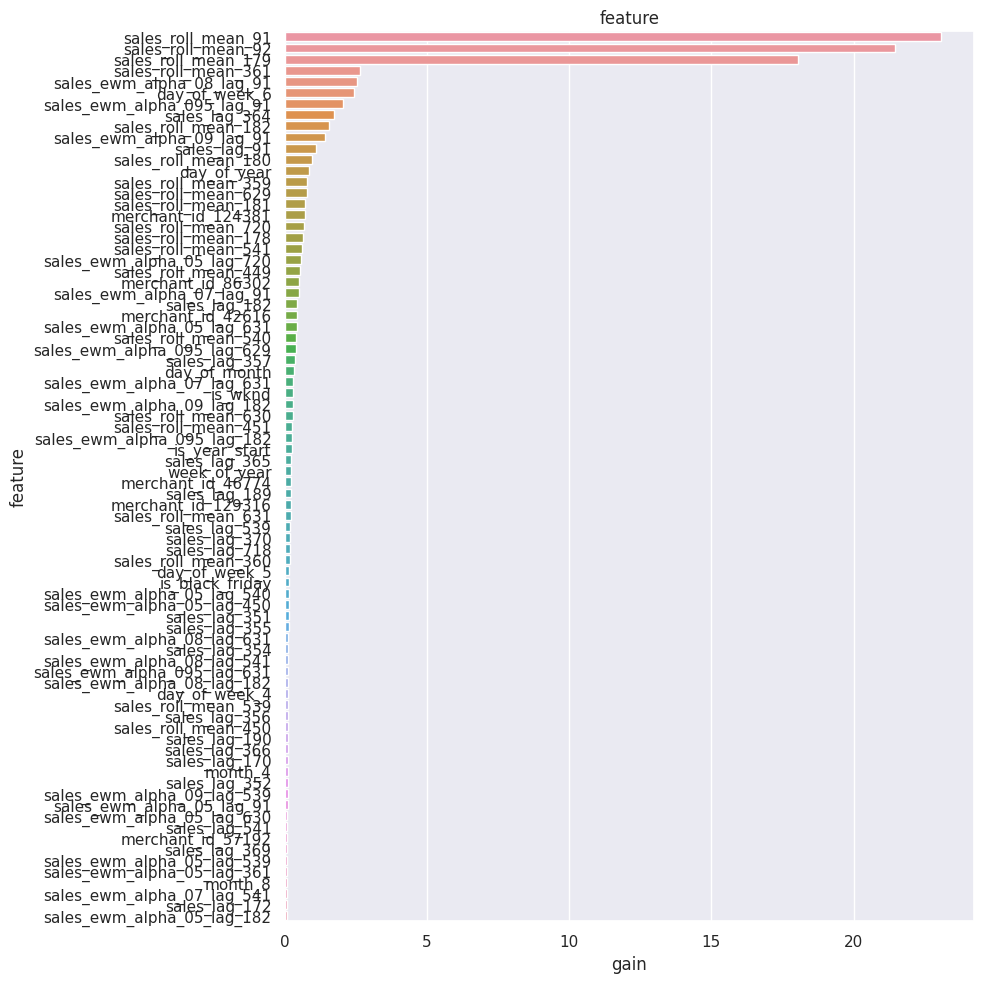

,feature,split,gain
64,sales_roll_mean_91,184,23.078392
65,sales_roll_mean_92,120,21.453979
67,sales_roll_mean_179,65,18.052791
73,sales_roll_mean_361,47,2.634496
124,sales_ewm_alpha_08_lag_91,29,2.538540
...,...,...,...
200,month_1,0,0.000000
10,is_year_end,0,0.000000
8,is_quarter_end,0,0.000000
196,day_of_week_3,0,0.000000


In [25]:
def plot_lgb_importances(model, plot=False, num=10):
    gain = model.feature_importance('gain')
    feat_imp = pd.DataFrame({'feature': model.feature_name(),
                             'split': model.feature_importance('split'),
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:num])
        plt.title('feature')
        plt.tight_layout()
        plt.show()
    else:
        print(feat_imp.head(num))
    return feat_imp

plot_lgb_importances(final_model, num=80, plot=True)

In [26]:
feat_imp = plot_lgb_importances(final_model, num=212)
importance_zero = feat_imp[feat_imp["gain"] == 0]["feature"].values
imp_feats = [col for col in cols if col not in importance_zero]
len(imp_feats), len(feat_imp)

                       feature  split       gain
64          sales_roll_mean_91    184  23.078392
65          sales_roll_mean_92    120  21.453979
67         sales_roll_mean_179     65  18.052791
73         sales_roll_mean_361     47   2.634496
124  sales_ewm_alpha_08_lag_91     29   2.538540
..                         ...    ...        ...
200                    month_1      0   0.000000
10                 is_year_end      0   0.000000
8               is_quarter_end      0   0.000000
196              day_of_week_3      0   0.000000
201                    month_2      0   0.000000

[212 rows x 3 columns]


(207, 212)

########################
# FINAL MODEL
########################

In [27]:
train = df[df["transaction_date"] < "2020-10-01"]
Y_train = train["Total_Transaction"]
X_train = train[imp_feats]

test = df[df["transaction_date"] >= "2020-10-01"]
X_test = test[imp_feats]

final_params = study.best_trial.params.copy()
final_params.update({
    'objective': 'regression',
    'metric': 'None',     # because you're using custom feval (SMAPE)
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'nthread': -1
})


# Create LightGBM dataset
lgb_final = lgb.Dataset(data=X_train, label=Y_train, feature_name=imp_feats)

# Train the final LightGBM model (no early stopping or validation at this stage)
final_model = lgb.train(
    params=final_params,
    train_set=lgb_final,
    num_boost_round=1000)

# these are not the real sales amounts, we applied log transformation
test_preds = final_model.predict(X_test, num_iteration=final_model.best_iteration)


test_preds = np.expm1(test_preds)  # Reversing log1p 
test_preds.shape


(644,)

########################
# FINAL PREDICTIONS
########################

In [28]:
test.head()

submission["Total_Transaction_Pred"] = test_preds  # test_preds must be same length as this df

submission.to_csv("Iyzico_submission.csv", index=False)

submission.head()

,merchant_id,transaction_date,Total_Transaction_Pred
7023,535,2020-10-01,2442.494084
7024,42616,2020-10-01,963.406572
7025,46774,2020-10-01,2992.729630
7026,57192,2020-10-01,1186.404318
7027,86302,2020-10-01,3008.827298
